**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 12: Representation learning

**Content:**
- Part 1: Visualizing High-Dimensional Data
- Part 2: Neural Autoencoders - Reconstruction
- Part 3: Neural Autoencoders - Classification
- Part 4: Neural Autoencoders - Generation with GMMs (Optional)

**Objectives:**
- Understand the purpose of representation learning and low-dimensional embeddings
- Apply PCA, Laplacian Eigenmaps, and t-SNE to visualize high-dimensional data
- Interpret and compare different types of learned representations
- Train an autoencoder and evaluate its reconstructions and latent space
- Use latent representations for simple classification and generative modeling


In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding # For Laplacian Eigenmaps
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Helper functions
def gauss_2d(centroid, ccov, std=2, points=100):
    """
    Returns two vectors representing slice through gaussian, cut at given standard deviation.

    Parameters:
    centroid (array-like): The centroid of the Gaussian distribution.
    ccov (array-like): The covariance matrix of the Gaussian distribution.
    std (float, optional): The standard deviation at which to cut the Gaussian distribution. Default is 2.
    points (int, optional): The number of points to sample along the slice. Default is 100.

    Returns:
    tuple: A tuple containing two vectors representing the slice through the Gaussian distribution.
    """
    mean = np.c_[centroid]
    tt = np.c_[np.linspace(0, 2 * np.pi, points)]
    x = np.cos(tt)
    y = np.sin(tt)
    ap = np.concatenate((x, y), axis=1).T
    d, v = np.linalg.eig(ccov)
    d = std * np.sqrt(np.diag(d))
    bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1]))
    return bp[0, :], bp[1, :]

def clusterplot(X, clusterid=None, centroids=None, y=None, covariances=None):
    
    if clusterid is not None:
        for i, pred_class in enumerate(np.unique(clusterid)):
            mask = (clusterid == pred_class)
            plt.scatter(X[mask, 0], X[mask, 1], s=100, facecolors=f'C{i}', label=f'Predicted class {pred_class}', linewidth=5)

    for i, true_class in enumerate(np.unique(y)):
        mask = (y == true_class)
        plt.scatter(X[mask, 0], X[mask, 1], s=50, c=f"C{i}", edgecolors='k', label=f'True class {true_class}')

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')

    if covariances is not None:
        for i in range(len(centroids)):
            x1, x2 = gauss_2d(centroids[i], covariances[i])
            plt.plot(x1, x2, "-", color=f'C{i}', linewidth=3)

    plt.title("Cluster Plot")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(ncols=2)

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_representation_w_imgs(X_rep, X_imgs, labels, selected_digits, zoom=0.6):
    # Make a figure
    fig, ax = plt.subplots(figsize=(10, 6))
    # Compute true min/max of the latent space
    x_min, x_max = X_rep[:,0].min(), X_rep[:,0].max()
    y_min, y_max = X_rep[:,1].min(), X_rep[:,1].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    for digit in selected_digits:
        mask = (labels == digit)
        xs = X_rep[mask][:, 0]
        ys = X_rep[mask][:, 1]
        imgs = X_imgs[mask]

        for x, y, img in zip(xs, ys, imgs):
            thumbnail = img.reshape(16, 16)
            imagebox = OffsetImage(thumbnail, cmap="gray_r", zoom=zoom)

            # place it at (x,y)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)

    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.title("Representations with images")
    plt.show()
    plt.close()    


---
## Introduction:

High-dimensional data often has an underlying low-dimensional structure, as we already saw with PCA. Representation learning aims to uncover this structure by learning new, more informative representations of the data in lower dimensions.

A representation is a transformation of raw data $\boldsymbol{x}$ into a new space $\boldsymbol{z}$ through a mapping, $\boldsymbol{z} = f\left(\boldsymbol{x}\right)$.

The resulting representation $\boldsymbol{z}$ is a vector whose coordinates capture relevant structure or variation in the data. A good representation makes the data easier to work with - whether for visualization, exploration, clustering, or downstream prediction tasks, by emphasizing informative patterns. Some examples of what a good representation might capture include:

- **Images**: orientation, lighting, shape, texture, or the presence of specific objects.
- **Text**: semantic meaning (e.g., topic or sentiment), grammar, or relationships between words.
- **Audio**: pitch, timbre, rhythm, or speaker identity.
- **Tabular data**: underlying factors such as customer preference, biological state, or economic trend.

This week we will explore several approaches to representation learning on the *digits* image dataset. We begin with PCA, Laplacian Eigenmaps, and t-SNE, which are widely used for visualizing high-dimensional datasets in two or three dimensions. 
We then look at neural autoencoders, which learn representations through reconstruction. Autoencoders will allow us to explore the latent space for visualization, classification, reconstruction, and even generation using a Gaussian Mixture Model.


---
## Part 1: Visualizing High-Dimensional Data

In this first part, we will explore three fundamental techniques for learning low-dimensional representations of high-dimensional data: PCA, Laplacian Eigenmaps, and t-SNE, all of which are mainly used for visualization of data. Each of these methods provides a way to map data $\boldsymbol{x}$ into a new representation $\boldsymbol{z}$ that reveals structure not easily seen in the original space.

PCA finds directions of maximum variance through a linear transformation, giving a global overview of the data in a reduced space. Laplacian Eigenmaps, in contrast, use the geometry of a neighborhood graph to preserve local relationships, capturing nonlinear structure. Finally, t-SNE focuses on preserving local similarities for visualization, often producing clear cluster-separated embeddings.

In the following exercises, you will apply all three methods to obtain meaningful 2-dimensional representations of the *digits* dataset and compare how each technique captures different aspects of its structure.

We start by loading the digits dataset, we will be loading all digits, but you're welcome to play around with how the representations are shaped with fewer digits. 

In [2]:
selected_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def load_digits_data(selected_digits):

    # Load the digits dataset
    digits = np.load('data/digits.npy')

    # Split into features and labels
    X, y = digits[:, :-1].astype(np.float32), digits[:, -1].astype(np.int64)

    # Filter for selected digits
    mask = np.isin(y, selected_digits)
    X, y = X[mask], y[mask]
    return X, y

X, y = load_digits_data(selected_digits)

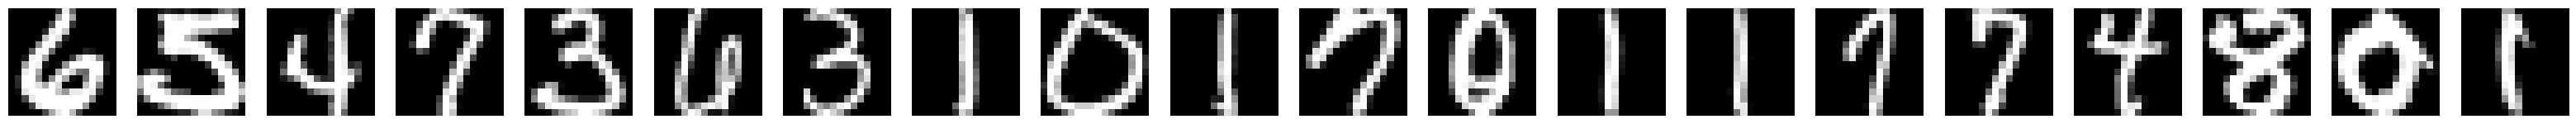

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(40, 4))
for i in range(20):
    axes[i].imshow(X[i].reshape(16, 16), cmap='gray')
    axes[i].axis('off')
plt.show()

### PCA

As you might remember, Principal Component Analysis (PCA) is a **linear** dimensionality reduction method that finds directions of maximal variance in the data. After centering the data, PCA computes an orthogonal basis ( $\boldsymbol{V}$ ) using the singular value decomposition:

$$
\tilde{\boldsymbol{X}} = \boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^\top .
$$

We obtain a $K$-dimensional representation of each data point, by projecting onto the first $K$ principal components:

$$
\boldsymbol{z}_i = \boldsymbol{V}_{(K)} \boldsymbol{x}_i .
$$

We will first use PCA to obtain a 2D embedding for visualization, and later examine the principal components themselves to see what directions PCA discovers in the data.

**Task 1.1:** Fit PCA on $\boldsymbol{x}$, transform $\boldsymbol{x}$ and save the representations as `X_pca`.

**Task 1.2:** Plot the first two dimensions of `X_pca`, use the provided `mask` to plot each digit at a time.
> *Hint:* Use `label=str(digit)` within `plt.scatter` to add the point-colors to the legend and `alpha=0.5` to make the points see-through.

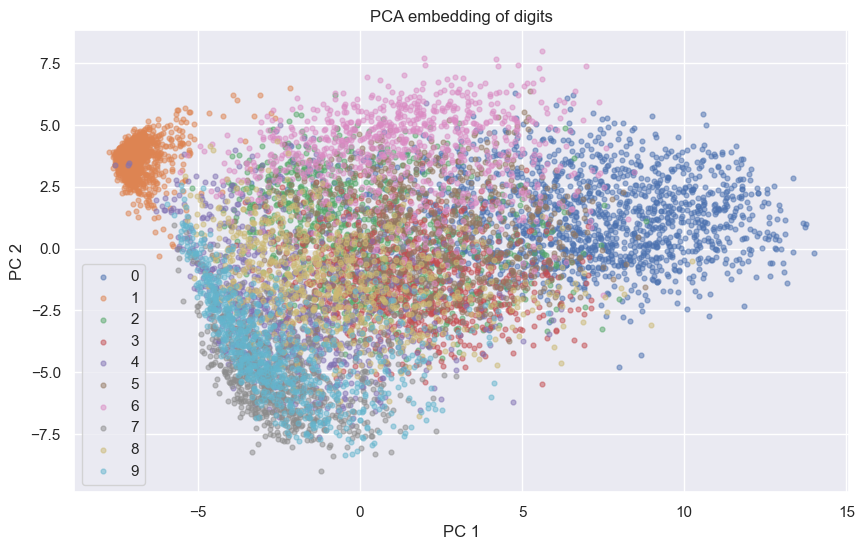

In [10]:
# 1.1 Fit PCA on x, transform x to X_pca
pca = PCA()
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
for digit in selected_digits:
    mask = (y == digit)
    # 1.2 Scatter X_pca for the masked digit
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=str(digit), alpha=0.5, s=12)
plt.legend()
plt.title("PCA embedding of digits")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

**Task 1.3:** Each principal component has shape $256$, reshape the principal components into 16x16 images and plot the first 10 - what do these images represent?

- *Answer*:

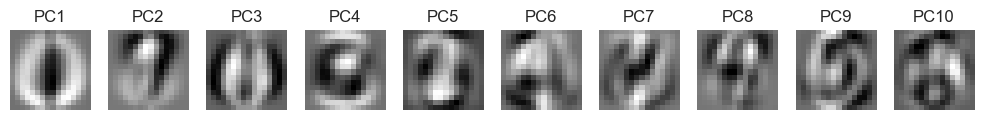

In [27]:
fig, axes = plt.subplots(1, 10, figsize=(10, 4))
#axes = axes.ravel() # for (2,5) layout

for number, (pc, ax) in enumerate(zip(pca.components_[:10], axes)):
    ax.imshow(pc.reshape(16,16), cmap='')
    ax.set_title(f'PC{number+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

**Task 1.4:** What structures or variations in the digit images do these principal components capture? For example, do these representations seem to have captured strokes, edges, thickness, or differences between certain digit shapes?
- *Answer:*

To get a better look at our representations, we can also plot the actual images on top of our space:

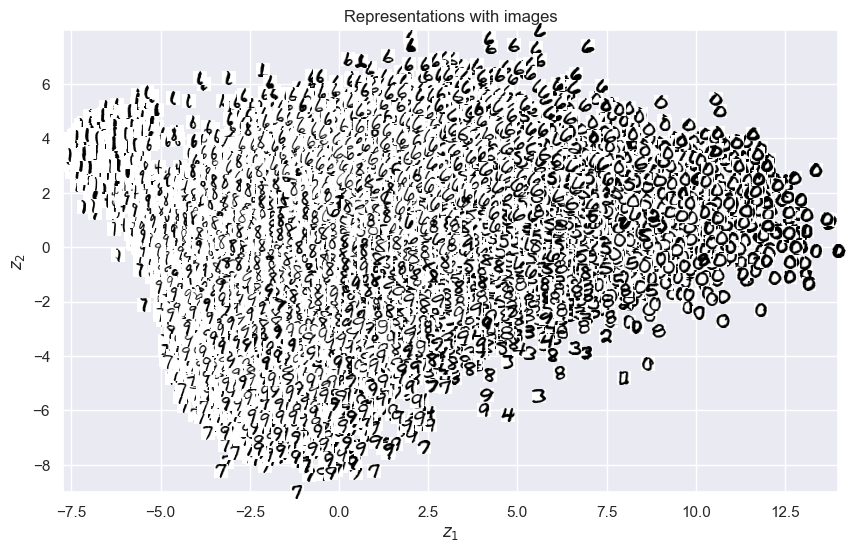

In [28]:
plot_representation_w_imgs(X_pca, X, y, selected_digits)

**Task 1.5:** What kind of structure do the axes of the representations seem to represent?
- *Answer:*

### Laplacian Eigenmaps (Optional)

Laplacian Eigenmaps is a nonlinear dimensionality reduction method that preserves local neighborhood structure. Instead of capturing global variance like PCA, it builds a graph connecting nearby points and finds an embedding where points that were close in the original space remain close in the low-dimensional space. This makes it well-suited for revealing curved or manifold-like structure in high-dimensional data.

**Task 1.5:** Fit and transform the Laplacian Eigenmaps on $\mathbf{x}$ using $n = 2$ components, save the representations as `X_lap`.
> *Hint:* Get Laplacian Eigenmaps using `SpectralEmbedding()` from SKLearn. 

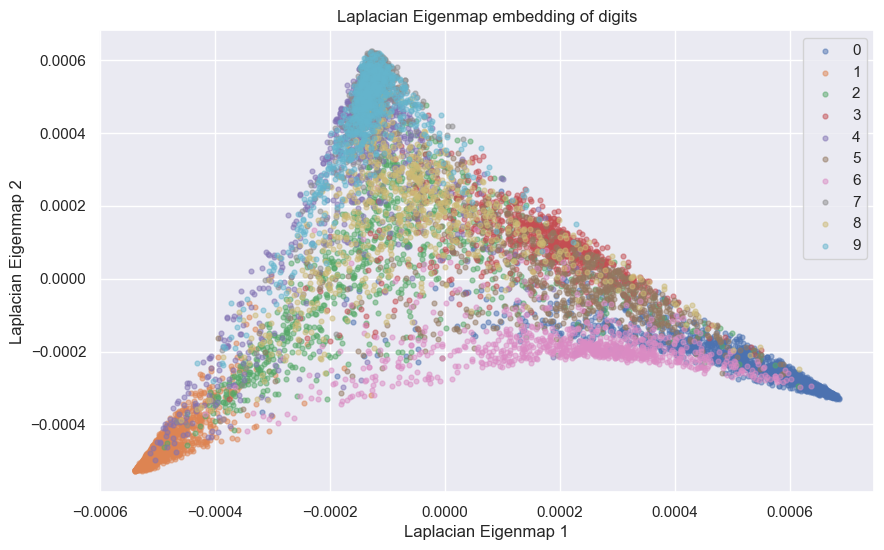

In [29]:
# 1.5 Fit and transform Laplacian Eigenmaps on X to X_lap
embedding = SpectralEmbedding(n_components=2)
X_lap = embedding.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
for digit in selected_digits:
    mask = (y == digit)
    plt.scatter(X_lap[mask, 0], X_lap[mask, 1], label=str(digit), alpha=0.5, s=12)

plt.legend()
plt.title("Laplacian Eigenmap embedding of digits")
plt.xlabel("Laplacian Eigenmap 1")
plt.ylabel("Laplacian Eigenmap 2")
plt.show()

We once again plot the images according to their representations:

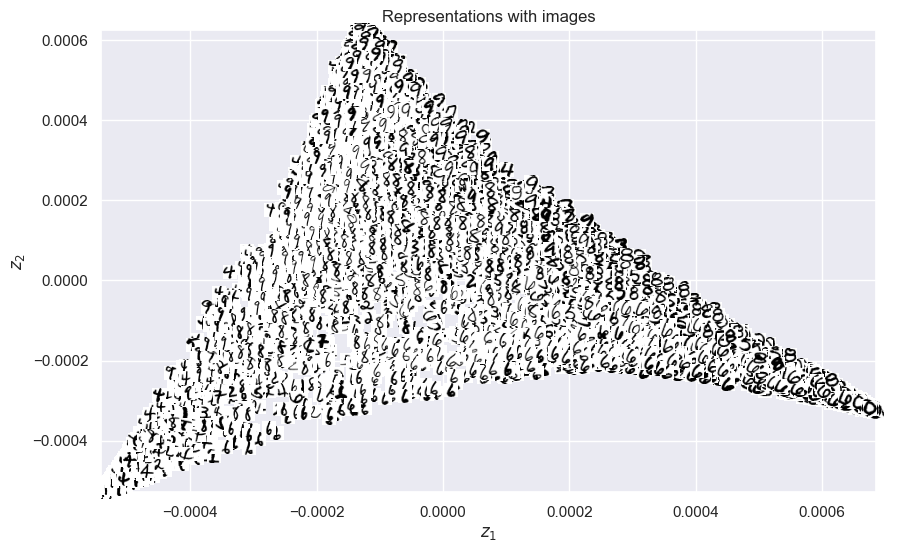

In [30]:
plot_representation_w_imgs(X_lap, X, y, selected_digits)

**Task 1.6:** Compare the Laplacian Eigenmaps embedding to the PCA embedding from earlier. In what ways does the structure revealed by Laplacian Eigenmaps differ from PCA? What does this representation seem to have captured?
- *Answer:*

Laplacian Eigenmaps differ from PCA in that they preserve local neighborhood relationships rather than global variance directions. While PCA spreads data along axes of maximum variance, Laplacian Eigenmaps produce embeddings where points from the same group are more tightly clustered, with fewer apparent outliers. This representation captures the intrinsic geometry of the data manifold, emphasizing relative distances and local connectivity, which often reveals clearer cluster structure than PCA.

#### t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction method designed specifically for visualization. It focuses on preserving local similarities: points that are close in the high-dimensional space are mapped to nearby points in the 2D embedding, while distant points are pushed apart. This often produces clear, visually separated clusters that reveal meaningful structure in complex datasets.

**Task 1.7:** Fit t-SNE on $\mathbf{x}$ with $n=2$ components, transform $\mathbf{x}$ and save the representations as `X_tsne`.
> *Hint:* Get the representations using `TSNE()` from SKLearn. 

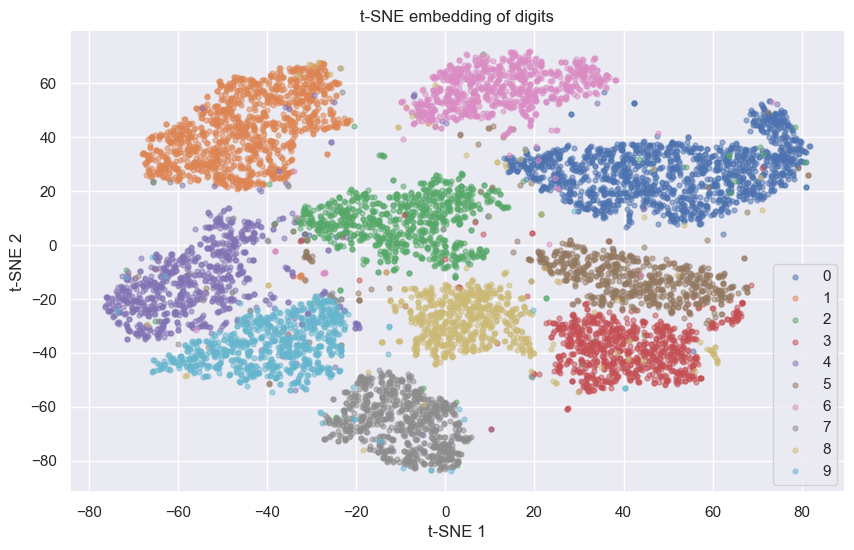

In [31]:
# 1.7 Fit t-SNE on X to X_tsne
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
for digit in selected_digits:
    mask = (y == digit)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=str(digit), alpha=0.5, s=12)

plt.legend()
plt.title("t-SNE embedding of digits")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

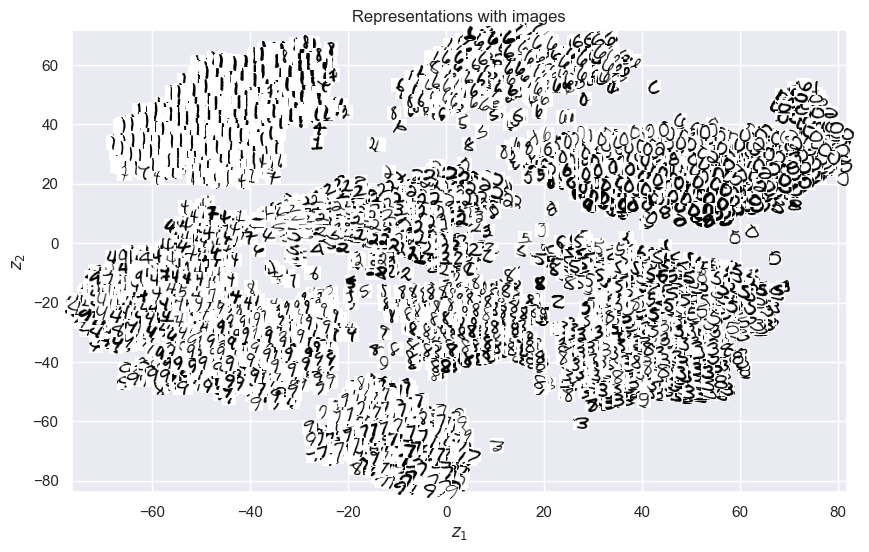

In [32]:
plot_representation_w_imgs(X_tsne, X, y, selected_digits)

**Task 1.8**: Inspect the 2D t-SNE embedding. How well are the different digits separated compared to PCA and Laplacian Eigenmaps? Comment on the clarity of the clusters and whether any digits still overlap.
- *Answer:*

  TSNE separated clusters very well - even in the middle of the graph, where PCA and LE didn't reach a good cluster resolution. Some digits still overlaps, but when we inspect how they are writen, we can see that these overlaps contain similarly shaped digits -> and in some cases, they are not writen very clearly. 9 and 7, 3 and 8, 4 with 9 and 8,... .


---
# Part 2: Neural Autoencoders - Reconstruction

Autoencoders are neural networks that learn a compressed representation of the data by trying to reconstruct the input after passing it through a low-dimensional bottleneck. 

They consist of two parts:

* an **encoder**
  $$\boldsymbol{z} = f_e(\boldsymbol{x})$$
  which maps the input to a latent representation, and

* a **decoder**
  $$\boldsymbol{x}' = f_d(\boldsymbol{z}) = f_d(f_e(\boldsymbol{x}))$$
  which reconstructs the original data from that representation.

The network is trained by minimizing a reconstruction loss $\mathcal{L}$, typically the mean squared error (MSE) between the original and the reconstructed image.
Which forces the encoder to learn features that capture the essential structure of the data, in order for the decoder to be able to reconstruct the original data.

PCA also fits into this picture - it can be viewed as a linear bottleneck model where data is projected into a low-dimensional subspace and then reconstructed from that subspace. Autoencoders generalize this idea by replacing the linear projection and reconstruction with neural networks, allowing the bottleneck representation to capture nonlinear structure that PCA cannot.

In the following exercises, we will train an autoencoder, inspect its reconstructions, and explore the structure of its latent space.

Below is a visual representation of the encoder, bottle-neck and decoder of an autoencoder. 

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <img src="AE.png" alt="Auto Encoder Illustration" style="width: 75%;">
</div>

Although the representations found in the bottle-neck can take any dimensionality, we will be working with 2-dimensional representations to ease visualization. You might find better results at higher latent dimensions - which you're very welcome to explore.

#### We'll start by defining our dataloader

We'll use a 80/20 train-test split, and stratify on the labels. 

In [33]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Construct a dataloader from the data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

We will now train the neural autoencoder to learn a 2-dimensional latent representation of the digit images.
The encoder maps each $16×16$ image (flattened to 256 dimensions) into a 2D latent code, and the decoder attempts to reconstruct the original image from that representation. The model is trained by minimizing the mean squared reconstruction error.

The network uses LeakyReLU activations, which behave like ReLU for positive inputs but allow a small negative slope for negative inputs. This avoids the “dead neuron” problem where ReLU units can get stuck outputting zero and stop learning entirely.

We also apply weight decay (L2 regularization) in the optimizer, helping to prevent overfitting by encouraging smaller weights, leading to smoother latent representations and better generalization of the decoder.

**Task 2.1:** Inspect the model architecture, how many weights does the model have?
- *Answer:*

**Task 2.2:** Initialize the model and loss function. 
> *Hint:* Remember to set the model to the correct device: `.to(device)`

>*Hint:* Use an MSE loss, with `reduction='sum'`.

Epoch 1/200 - Train Loss: 0.3645
Epoch 10/200 - Train Loss: 0.2344
Epoch 20/200 - Train Loss: 0.2204
Epoch 30/200 - Train Loss: 0.2097
Epoch 40/200 - Train Loss: 0.2018
Epoch 50/200 - Train Loss: 0.1975
Epoch 60/200 - Train Loss: 0.1933
Epoch 70/200 - Train Loss: 0.1892
Epoch 80/200 - Train Loss: 0.1891
Epoch 90/200 - Train Loss: 0.1833
Epoch 100/200 - Train Loss: 0.1812
Epoch 110/200 - Train Loss: 0.1797
Epoch 120/200 - Train Loss: 0.1759
Epoch 130/200 - Train Loss: 0.1776
Epoch 140/200 - Train Loss: 0.1724
Epoch 150/200 - Train Loss: 0.1720
Epoch 160/200 - Train Loss: 0.1697
Epoch 170/200 - Train Loss: 0.1715
Epoch 180/200 - Train Loss: 0.1678
Epoch 190/200 - Train Loss: 0.1683
Epoch 200/200 - Train Loss: 0.1661


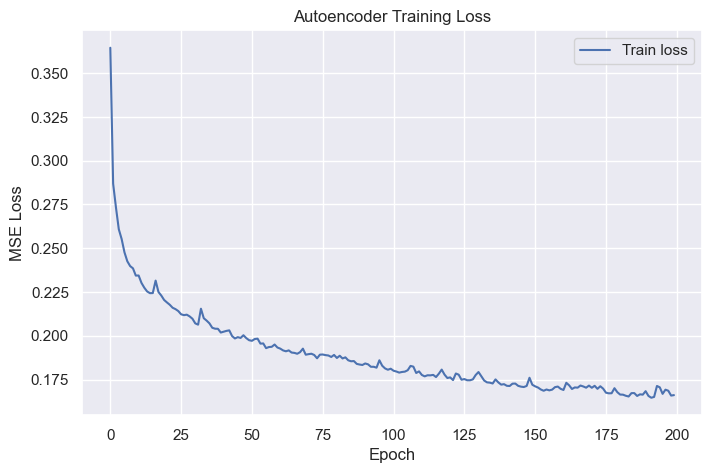

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        # ----- ENCODER -----
        self.encoder = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.02),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.02),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.02),

            nn.Linear(64, latent_dim),
        )

        # ----- DECODER -----
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.02),

            nn.Linear(64, 128),
            nn.LeakyReLU(0.02),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.02),  
            
            nn.Linear(256, 256),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

torch.manual_seed(42)

# --- Training setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2.2 Define model and loss function
# YOUR CODE HERE
model = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)

# --- Training loop ---
epochs = 200
train_losses = []

def train_model(train_dataloader, model, epochs, criterion, optimizer, device):

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for imgs, _ in train_dataloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs, _ = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        
        train_losses.append(total_train_loss / len(train_dataloader.dataset))

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_train_loss/len(train_dataloader.dataset):.4f}")

    return model, train_losses

model, train_losses = train_model(train_dataloader, model, epochs, criterion, optimizer, device)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()

We'll now visualize our reconstructions. 

**Task 2.3:** Extract a batch of images from the test_loader - input the images into the AE, and get the reconstructed images, save them as `reconstructed`.
> *Hint:* You can extract a batch by using `next(iter(test_dataloader))`.

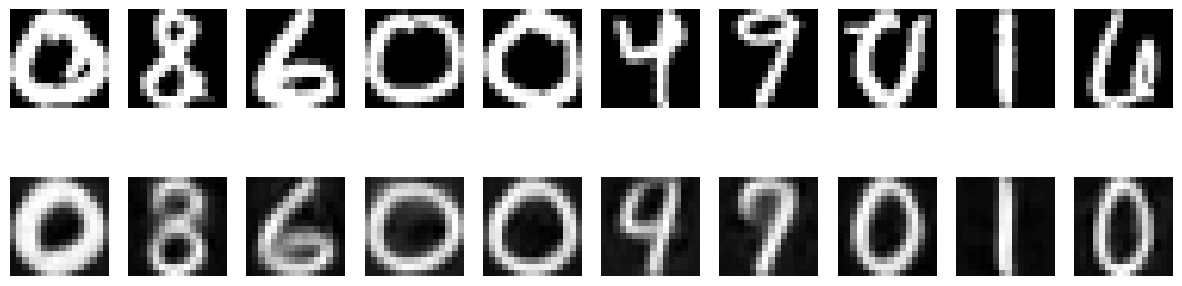

In [39]:
model.eval()
# 2.3 Extract a batch of images from the test_loader,
# input the images into the AE, and get the reconstructed images, save them as reconstructed.
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
reconstructed, _ = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(16, 16), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(16, 16), cmap='gray')
    axes[1, i].axis('off')
plt.show()

**Task 2.4:** How well did the Autoencoder manage to reconstruct the images? Are there any mistakes - if so, do these make sense to you?
- *Answer:*

**Task 2.5:** Which digits would you imagine have representations that lie close together in the latent space?
- *Answer:*

**Task 2.6:** Try increasing the latent dimension, can you get the reconstructions to be better? 
> *Hint:* This will make visualization of the latent dimension more difficult in the next tasks, so be sure to change it back once you've played around. 

We will now visualize the latent representations.

**Task 2.7:** Get the latent representations from the autoencoder, append the representations and labels to the lists.

Text(0, 0.5, '$z_2$')

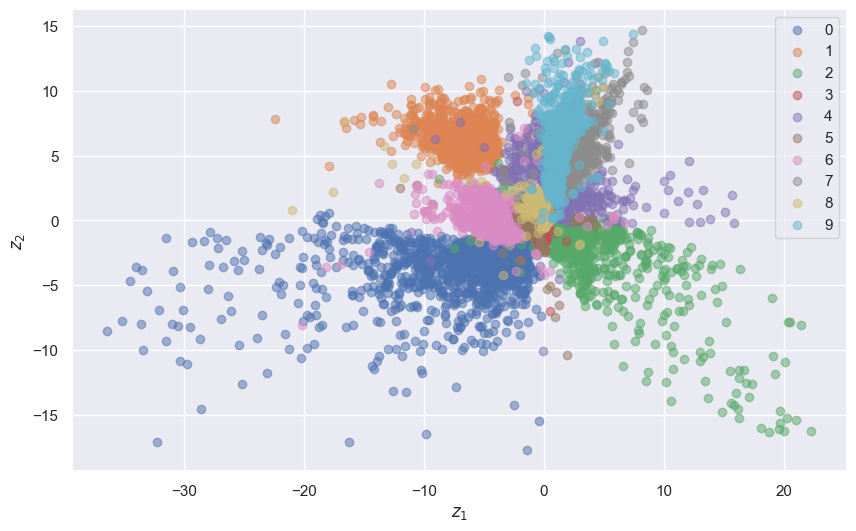

In [40]:
train_images = []
train_zs = []
train_labels = []

for imgs, labels in train_dataloader:
    # 2.7 Get the latent representations from the autoencoder, append the representations and labels to the lists.
    train_images.append(imgs)
    reconstructions, zs = model(imgs)
    train_zs.append(zs)
    train_labels.append(labels)

# Concatenate all batches
train_images = torch.cat(train_images).cpu().detach().numpy()
train_zs = torch.cat(train_zs).cpu().detach().numpy()
train_labels = torch.cat(train_labels).cpu().detach().numpy()

# Plot the latent representations
plt.figure(figsize=(10, 6))
for digit in selected_digits:
    mask = (train_labels == digit)
    plt.scatter(train_zs[mask, 0], train_zs[mask, 1], label=str(digit), alpha=0.5, marker='o')
    
plt.legend()
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

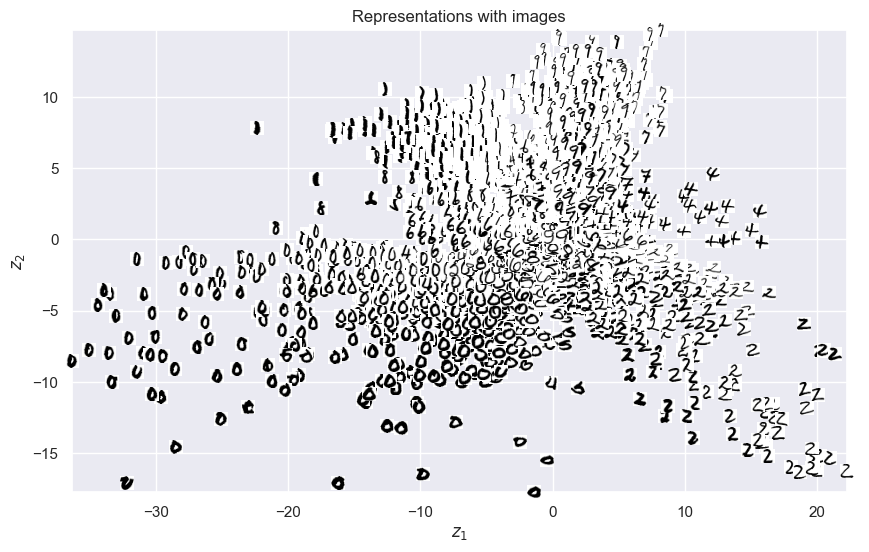

In [41]:
plot_representation_w_imgs(train_zs, train_images, train_labels, selected_digits)

**Task 2.8:** Look at the representations, what kind of information does it seem like the autoencoder has managed to encode? Shape, stroke thickness, rotation?


---
# Part 3: Neural Autoencoders - Classification

We will now use the representations for a KNN classifier - i.e. we are essentially removing the decoder from the autoencoder, and replacing it with a KNN. 

**Task 3.1:** Based on the plots you've seen above, do you think the classification will outperform a KNN trained directly on the images? Why / Why not?
> *Hint:* What is the goal of the representations? Has the autoencoder been directly trained to separate the classes?

**Task 3.2:** Fit a KNN with $k=5$ neighbours on the latent representations of our training set, `train_zs`.

In [47]:
# 3.2: Fit a KNN with k=5 neighbours on the latent representations
knn_model  = KNeighborsClassifier(n_neighbors=5)
knn_model .fit(train_zs, train_labels)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


**Task 3.3:** Extract latent representations on the test set from the model, append representations and labels to the lists.

In [53]:
# Predict on test set
test_zs = []
test_labels = []
for images, labels in test_dataloader:
    # 3.3 Extract latent representations from the model, append representations and labels to the lists.
    reconstruction, zs = model(images)
    test_zs.append(zs)
    test_labels.append(labels)

test_zs = torch.cat(test_zs).cpu().detach().numpy()
test_labels = torch.cat(test_labels).cpu().detach().numpy()

y_preds = knn_model.predict(test_zs)

UsageError: Line magic function `%%timeit` not found.


We'll create a confusion matrix.

**Task 3.4:** Are the errors in line with what you might have expected from the visualization of the latent space?

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       311
           1       0.97      0.98      0.98       254
           2       0.89      0.90      0.89       186
           3       0.85      0.86      0.86       165
           4       0.75      0.69      0.72       170
           5       0.86      0.85      0.85       143
           6       0.88      0.92      0.90       167
           7       0.94      0.89      0.91       158
           8       0.86      0.84      0.85       142
           9       0.73      0.80      0.77       164

    accuracy                           0.88      1860
   macro avg       0.87      0.87      0.87      1860
weighted avg       0.88      0.88      0.88      1860



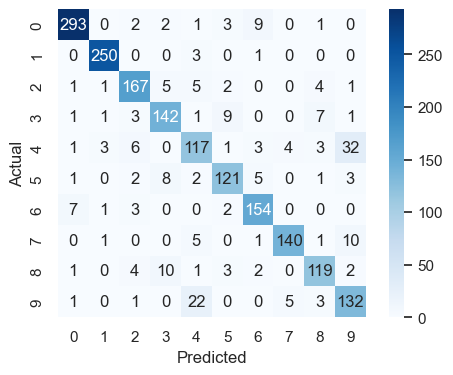

In [49]:
print(classification_report(test_labels, y_preds))

# Plot the confusion matrix
cm = confusion_matrix(test_labels, y_preds)
df_cm = pd.DataFrame(cm, index=selected_digits, columns=selected_digits)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.gca().set_aspect('equal')
plt.show()

We will now move on to do a KNN directly on the images. 

**Task 3.5:** Fit a KNN with $k=5$ neighbours on the images, `X_train`.

In [50]:
# 3.5: Fit a KNN with k=5 neighbours on the images X_train
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


**Task 3.6:** Use your KNN model to predict on the test images, `X_test` - save the predictions as `y_preds`. 

In [51]:
# 3.6: Use your KNN model to predict on the test images, X_test - save the predictions as y_preds.
y_preds = knn_model.predict(X_test)

We will once again do a confusion matrix.

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       311
           1       0.98      0.99      0.98       254
           2       0.94      0.94      0.94       186
           3       0.98      0.95      0.96       165
           4       0.94      0.88      0.91       170
           5       0.99      0.94      0.96       143
           6       0.95      0.98      0.96       167
           7       0.92      0.97      0.95       158
           8       0.99      0.91      0.95       142
           9       0.90      0.96      0.93       164

    accuracy                           0.95      1860
   macro avg       0.96      0.95      0.95      1860
weighted avg       0.96      0.95      0.95      1860



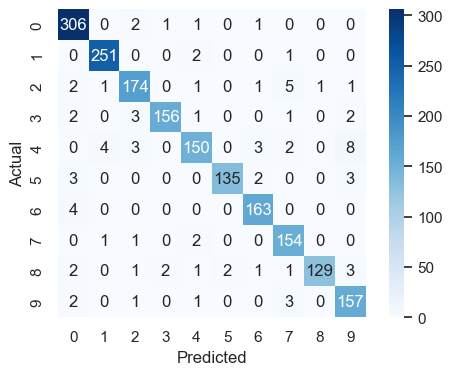

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, y_preds))

# Plot the confusion matrix nicely
cm = confusion_matrix(test_labels, y_preds)
df_cm = pd.DataFrame(cm, index=selected_digits, columns=selected_digits)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.gca().set_aspect('equal')
plt.show()

**Task 3.7:** Which model has better performance? Why do you think that is?

model directly trained on X_train. I think it is because in order to transform data into a latent space, some information had to be lost which resulted in worse performance.

**Task 3.8:** Though we might not see the same performance, can you think of any bonuses we might gain from classifying on the latent representations?
> *Hint:* Try adding `%%timeit -n 100 -r 5` to the top of the KNN prediction code-blocks for both the latent representations and the images. Which is faster - and why? Think of how KNNs do prediction. 


---
# Part 4: Neural Autoencoders - Generation with GMMs (Optional)

Last week we worked with Gaussian Mixture Models (GMMs) as an *unsupervised* method that models a probability distribution over the data. One appealing property of a GMM is that it is *generative*: once the model is fitted, we can generate new samples by

1. selecting a mixture component according to its weight ($w_k$), and
2. sampling a point from the corresponding Gaussian distribution.

In this part, we will combine this idea with the *latent space* of our autoencoder. Instead of fitting a GMM directly to the high-dimensional image space, we fit it to the *low-dimensional latent representations*, where the structure of the data is often much simpler. By sampling in the latent space and decoding the samples through the autoencoder, we obtain new synthetic digit images.

To keep the results visually clear, we will work with a reduced subset of digits and retrain the autoencoder on this smaller dataset.

> **Note:** This approach is a simple workaround for generative modeling using standard autoencoders. A more principled method is the **Variational Autoencoder (VAE)**, which is trained to produce a smooth, Gaussian-like latent space by construction. VAEs ensure that sampling in the latent space corresponds to meaningful outputs, whereas standard autoencoders may learn irregular or disconnected latent regions. Here we use a GMM as an intuitive approximation of that idea.


In [54]:
# Load reduced digits data
X, y = load_digits_data(selected_digits=[0, 4])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Construct a dataloader from the data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the autoencoder again on the reduced dataset
torch.manual_seed(42)

model = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-3)

model, train_losses = train_model(train_dataloader, model, epochs, criterion, optimizer, device)

Epoch 1/200 - Train Loss: 6381.4387
Epoch 10/200 - Train Loss: 2366.8870
Epoch 20/200 - Train Loss: 2232.7082
Epoch 30/200 - Train Loss: 2128.2253
Epoch 40/200 - Train Loss: 2065.6124
Epoch 50/200 - Train Loss: 2033.6619
Epoch 60/200 - Train Loss: 2003.1591
Epoch 70/200 - Train Loss: 1969.0121
Epoch 80/200 - Train Loss: 1941.7210
Epoch 90/200 - Train Loss: 1922.9145
Epoch 100/200 - Train Loss: 1907.3012
Epoch 110/200 - Train Loss: 1892.4939
Epoch 120/200 - Train Loss: 1880.2653
Epoch 130/200 - Train Loss: 1869.1147
Epoch 140/200 - Train Loss: 1864.0432
Epoch 150/200 - Train Loss: 1855.6640
Epoch 160/200 - Train Loss: 1846.5543
Epoch 170/200 - Train Loss: 1836.7220
Epoch 180/200 - Train Loss: 1829.7863
Epoch 190/200 - Train Loss: 1819.6517
Epoch 200/200 - Train Loss: 1812.9837


We collect the representations and plot them:

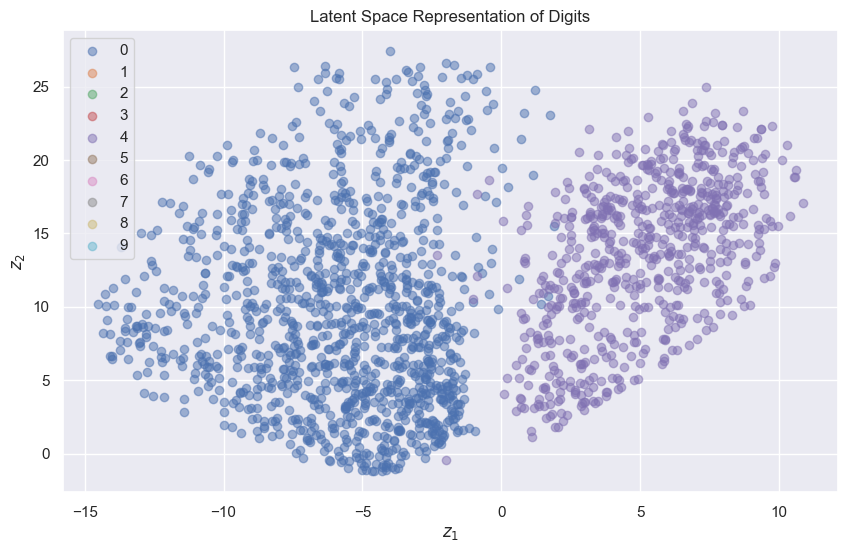

In [57]:
train_images = []
train_reconstructions = []
train_zs = []
train_labels = []

for imgs, labels in train_dataloader:
    train_images.append(imgs)
    reconstructions, zs = model(imgs)
    train_reconstructions.append(reconstructions)
    train_zs.append(zs)
    train_labels.append(labels)

# Concatenate all batches
train_images = torch.cat(train_images).cpu().detach().numpy()
train_reconstructions = torch.cat(train_reconstructions).cpu().detach().numpy()
train_zs = torch.cat(train_zs).cpu().detach().numpy()
train_labels = torch.cat(train_labels).cpu().detach().numpy()

# Plot the latent representations
plt.figure(figsize=(10, 6))
for digit in selected_digits:
    mask = (train_labels == digit)
    plt.scatter(train_zs[mask, 0], train_zs[mask, 1], label=str(digit), alpha=0.5, marker='o')
    
plt.legend()
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Latent Space Representation of Digits')
plt.show()

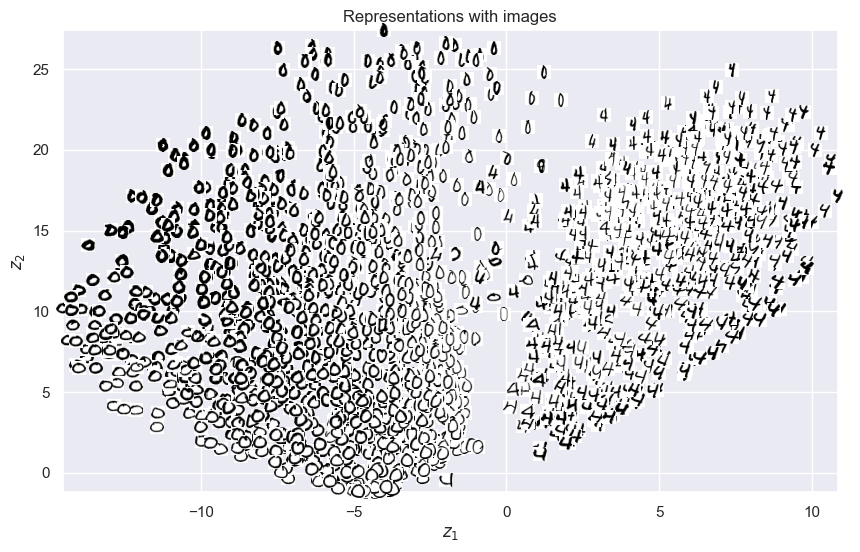

In [58]:
plot_representation_w_imgs(train_zs, train_images, train_labels, selected_digits)

As you might recall from last week, we can use the Bayesian Information Criteria (BIC) to find the optimal number of clusters.

**Task 4.1:** Fit the GMM inside the loop on `train_zs`, get the BIC-score and append it to the list. 

Optimal number of components: 7


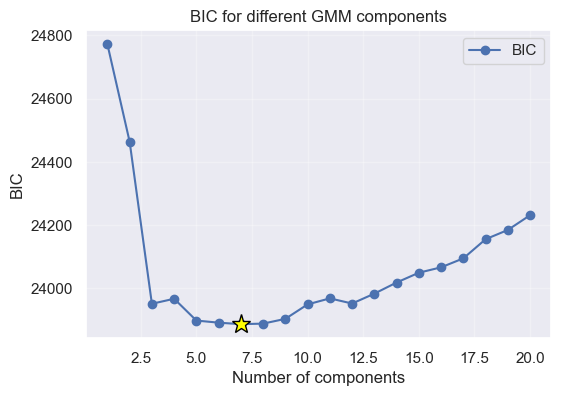

In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Standardize the data ----
#scaler = StandardScaler()
#train_zs_scaled = scaler.fit_transform(train_zs)

# ---- 2. Optimize number of components using BIC ----
n_components = np.arange(1, 21)
bics = []
models = {}

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=seed)
    gmm.fit(train_zs)
    bic_value = gmm.bic(train_zs)
    bics.append(bic_value)

# ---- 3. Find the optimal number ----
optimal_n = n_components[np.argmin(bics)]
print(f"Optimal number of components: {optimal_n}")

# ---- 4. Plot BIC scores ----
plt.figure(figsize=(6, 4))
plt.plot(n_components, bics, marker='o', label="BIC")
plt.plot(optimal_n, bics[np.argmin(bics)], marker='*', markersize=14,markerfacecolor='yellow', markeredgecolor='black')
plt.xlabel("Number of components")
plt.ylabel("BIC")
plt.title("BIC for different GMM components")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Task 4.2:** Fit a GMM with the optimal number of components, save the predictions as `pred_clusters`.

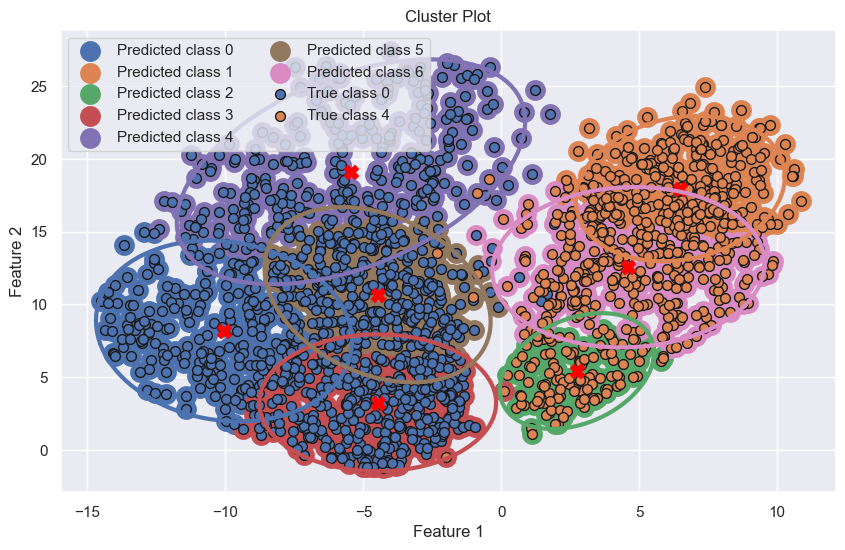

In [60]:
# 4.2 Fit a GMM with the optimal number of components, save the predictions as `pred_clusters`.
gmm = GaussianMixture(n_components=optimal_n, random_state=42)

# gmm = GaussianMixture(n_components=optimal_n, random_state=3)
gmm.fit(train_zs)
pred_clusters = gmm.predict(train_zs)

# Plot the clustering results
means = gmm.means_
covariances = gmm.covariances_
plt.figure(figsize=(10,6))
clusterplot(train_zs, clusterid=pred_clusters, centroids=means, y=train_labels, covariances=covariances)
plt.show()

We can now use the GMM to generate new latent representations and use our autoencoder to decode them - generating completely new handwritten digits within our distributions. 

**Task 4.3:** Sample 20 points from the GMM. Forward the samples through the decoder of the autoencoder.
> *Hint:* Convert the samples to torch: `generated_zs = torch.tensor(generated_zs, dtype=torch.float32)`

C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


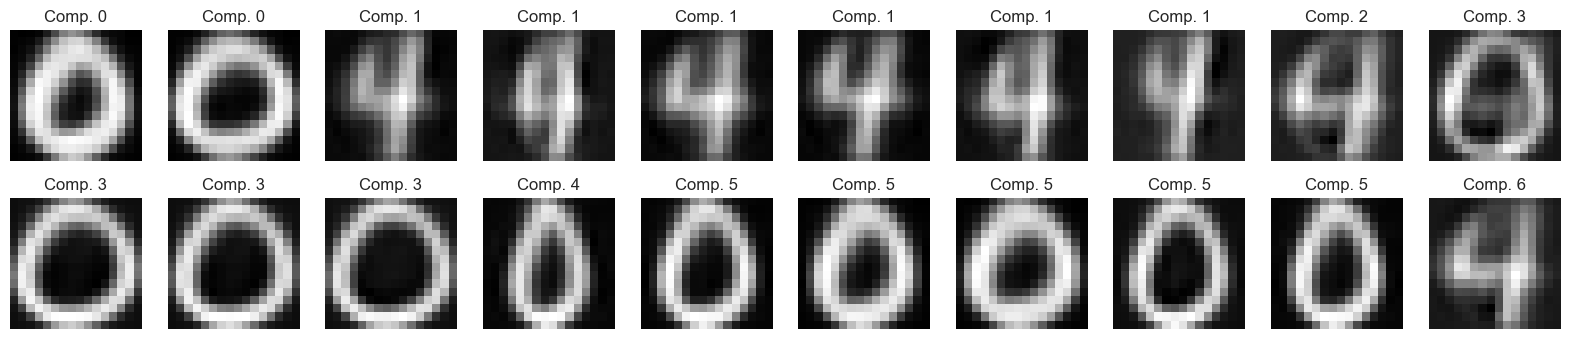

In [61]:
num_samples = 20
np.random.seed(seed)

# 4.2 Sample from GMM
generated_zs, component_labels = gmm.sample(num_samples)
generated_zs = torch.tensor(generated_zs, dtype=torch.float32)
generated_imgs = model.decoder(generated_zs)

# Sort according to component labels
sorted_indices = np.argsort(component_labels)
generated_imgs = generated_imgs[sorted_indices]
component_labels = component_labels[sorted_indices]

imgs_per_row = 10
n_rows = num_samples // imgs_per_row

fig, axs = plt.subplots(n_rows, imgs_per_row, figsize=(2*imgs_per_row, 2*n_rows))
for i in range(num_samples):
    axs[i // imgs_per_row, i % imgs_per_row].imshow(generated_imgs[i].detach().numpy().reshape(16, 16), cmap='gray')
    axs[i // imgs_per_row, i % imgs_per_row].set_title(f'Comp. {component_labels[i]}')
    axs[i // imgs_per_row, i % imgs_per_row].axis('off')
plt.show()

**Task 4.4:** Do all components produce visually plausible digits, or do some produce artifacts? What might this say about how well the GMM approximates the latent distribution?

**Task 4.5:** Can you tell a difference in how the different components generate digits?